In [248]:
import yfinance as yf
import pandas as pd
import numpy as np
import hvplot.pandas
from finta import TA

**YFinance:**

In [250]:
# set ticker ('BTC-USD', 'ETH-USD')
ticker = 'ETH-USD'
cc = yf.Ticker(f"{ticker}")

# set dates for historical data
start = '2018-02-01'
end = '2023-01-24'

hist = cc.history(start=f"{start}", end=f"{end}")
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-02-01 00:00:00+00:00,1119.369995,1161.349976,984.818970,1036.790039,5261680128,0.0,0.0
2018-02-02 00:00:00+00:00,1035.770020,1035.770020,757.979980,915.784973,6713290240,0.0,0.0
2018-02-03 00:00:00+00:00,919.210999,991.942993,847.690002,964.018982,3243480064,0.0,0.0
2018-02-04 00:00:00+00:00,964.666992,969.031982,805.064026,834.682007,2997090048,0.0,0.0
2018-02-05 00:00:00+00:00,834.958008,856.645996,644.598999,697.950989,4269530112,0.0,0.0


In [251]:
# just close column
historical = pd.DataFrame(hist)
historical_close = historical.drop(['Open','High', 'Low','Volume', 'Dividends', 'Stock Splits'], axis=1)
historical_close.head()

,Close
Date,
2018-02-01 00:00:00+00:00,1036.790039
2018-02-02 00:00:00+00:00,915.784973
2018-02-03 00:00:00+00:00,964.018982
2018-02-04 00:00:00+00:00,834.682007
2018-02-05 00:00:00+00:00,697.950989


**Fear and Greed API:**

In [259]:
import requests

In [260]:
r = requests.get('https://api.alternative.me/fng/?limit=0')

In [261]:
# select 'data' and add to a dataframe
fg_df = pd.DataFrame(r.json()['data'])

In [262]:
# convert 'value' to int
fg_df.value = fg_df.value.astype(int)

# convert time format to datetime
fg_df.timestamp = pd.to_datetime(fg_df.timestamp, unit='s' )

# set date as index
fg_df.set_index('timestamp', inplace=True)

In [263]:
# drop all columns except 'value'
fg_df = fg_df.drop(['value_classification', 'time_until_update'], axis=1)

# flip oldest data to the top
fg_df = fg_df[::-1]

# convert date format to match 'historical_close'
fg_df.index = pd.to_datetime(fg_df.index).tz_localize('Etc/UCT')

fg_df.head()

,value
timestamp,
2018-02-01 00:00:00+00:00,30
2018-02-02 00:00:00+00:00,15
2018-02-03 00:00:00+00:00,40
2018-02-04 00:00:00+00:00,24
2018-02-05 00:00:00+00:00,11


**Combined:**

In [264]:
# rename index to match fg_df
historical.index.name = 'timestamp'

# combine historical price data with historical fear and greed
combined_df = pd.concat([fg_df, historical_close], axis=1, join='outer')

combined_df.head()

,value,Close
timestamp,,
2018-02-01 00:00:00+00:00,30.0,1036.790039
2018-02-02 00:00:00+00:00,15.0,915.784973
2018-02-03 00:00:00+00:00,40.0,964.018982
2018-02-04 00:00:00+00:00,24.0,834.682007
2018-02-05 00:00:00+00:00,11.0,697.950989


**Backtest:**

In [265]:
combined_df_ = combined_df.copy()

# add 'change' column using pct_change on 'Close'
combined_df_['change'] = combined_df_['Close'].pct_change()
combined_df_.tail()

,value,Close,change
timestamp,,,
2023-01-21 00:00:00+00:00,53.0,1627.118164,-0.019663
2023-01-22 00:00:00+00:00,53.0,1628.382080,0.000777
2023-01-23 00:00:00+00:00,50.0,1628.251099,-0.000080
2023-01-24 00:00:00+00:00,52.0,NaN,0.000000
2023-01-25 00:00:00+00:00,51.0,NaN,0.000000


**Algorithm Logic:**

- position 1.0 = Long Crypto (uptrend)

- position -1.0 = Short Crypto (downtrend)

- position 0.0 = Hold Stablecoin (no trend)

In [266]:
# algorithm

combined_df_['position'] = 0

# short when f&g is over 94 (f&g > 94 = -1)
for index, row in combined_df_.iterrows():
    if row['value'] >= 95:
        combined_df_.loc[index, 'position'] = -1.0

# long when f&g is over 45 and under 94 (93 > f&g > 45 = 1)
    elif row['value'] >= 46:
        combined_df_.loc[index, 'position'] = 1.0

# short when f&g is over 24 and less than 46 (46 > f&g > 24 = -1)
    elif row['value'] >= 25:
        combined_df_.loc[index, 'position'] = -1.0
# hold stables under 25 (f&g < 23 = 0.0)
    elif row['value'] < 25:
        combined_df_.loc[index, 'position'] = 0

combined_df_ = combined_df_.dropna()
combined_df_.head(15)

,value,Close,change,position
timestamp,,,,
2018-02-02 00:00:00+00:00,15.0,915.784973,-0.116711,0
2018-02-03 00:00:00+00:00,40.0,964.018982,0.052670,-1
2018-02-04 00:00:00+00:00,24.0,834.682007,-0.134164,0
2018-02-05 00:00:00+00:00,11.0,697.950989,-0.163812,0
2018-02-06 00:00:00+00:00,8.0,793.122009,0.136358,0
2018-02-07 00:00:00+00:00,36.0,757.067993,-0.045458,-1
2018-02-08 00:00:00+00:00,30.0,817.807007,0.080229,-1
2018-02-09 00:00:00+00:00,44.0,883.864990,0.080775,-1
2018-02-10 00:00:00+00:00,54.0,860.414978,-0.026531,1


In [267]:
# number of each position
combined_df_['position'].value_counts()

-1    673
 1    648
 0    493
Name: position, dtype: int64

**Returns:**

In [268]:
# calculate returns
strategy_returns = combined_df_.position.shift() * combined_df_.change

In [269]:
# plot to compare
fg_strat_plt = (strategy_returns +1).cumprod().hvplot(label = 'FG_strat')
cc_returns_plt = (combined_df_.change +1).cumprod().hvplot(label = 'CC')
fg_strat_plt * cc_returns_plt


:Overlay
   .Curve.FG_strat :Curve   [timestamp]   (0)
   .Curve.CC       :Curve   [timestamp]   (change)

In [270]:
# returns
fg_return = (strategy_returns + 1).cumprod()
cc_return = (combined_df_.change + 1).cumprod()
fg_final = fg_return[-1]
cc_final = cc_return[-1]
print(f'Fear and Greed strategy returns:  {round(fg_final, 2)}')
print(f'CC returns:  {round(cc_final, 2)}')

Fear and Greed strategy returns:  53.4
CC returns:  1.51


In [271]:
initial_investment = 1000

fg_inv_returns  = initial_investment * fg_final
cc_inv_returns = initial_investment * cc_final

print(f"Buying ${initial_investment} and holding: ${round(cc_inv_returns, 2)}")
print(f"${initial_investment} with fear and greed strategy: ${round(fg_inv_returns, 2)}")

Buying $1000 and holding: $1513.9
$1000 with fear and greed strategy: $53402.02


**Machine Learning:**

In [272]:
import pandas_ta as pa
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

**Target:**

In [273]:
# set ticker ('BTC-USD', 'ETH-USD')
ticker = 'ETH-USD'
cc = yf.Ticker(f"{ticker}")

# set dates for historical data
start = '2018-02-01'
end = '2023-01-24'

histo = cc.history(start=f"{start}", end=f"{end}")
histo.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-02-01 00:00:00+00:00,1119.369995,1161.349976,984.818970,1036.790039,5261680128,0.0,0.0
2018-02-02 00:00:00+00:00,1035.770020,1035.770020,757.979980,915.784973,6713290240,0.0,0.0
2018-02-03 00:00:00+00:00,919.210999,991.942993,847.690002,964.018982,3243480064,0.0,0.0
2018-02-04 00:00:00+00:00,964.666992,969.031982,805.064026,834.682007,2997090048,0.0,0.0
2018-02-05 00:00:00+00:00,834.958008,856.645996,644.598999,697.950989,4269530112,0.0,0.0


In [274]:
# all columns for finding target
historical = pd.DataFrame(histo)
historical_ = historical.drop(['Dividends', 'Stock Splits'], axis=1)
historical_['signal'] = combined_df_['position']
historical_ = historical_.dropna()
historical_.head()

,Open,High,Low,Close,Volume,signal
Date,,,,,,
2018-02-02 00:00:00+00:00,1035.770020,1035.770020,757.979980,915.784973,6713290240,0.0
2018-02-03 00:00:00+00:00,919.210999,991.942993,847.690002,964.018982,3243480064,-1.0
2018-02-04 00:00:00+00:00,964.666992,969.031982,805.064026,834.682007,2997090048,0.0
2018-02-05 00:00:00+00:00,834.958008,856.645996,644.598999,697.950989,4269530112,0.0
2018-02-06 00:00:00+00:00,707.737000,796.439026,574.419006,793.122009,6518269952,0.0


In [275]:
# Target column to show actual trend

pipdiff = 2500*1e-4 #for TP
SLTPRatio = 1/16 #pipdiff/Ratio gives SL
def mytarget(barsupfront, historical_):
    length = len(historical_)
    high = list(historical_['High'])
    low = list(historical_['Low'])
    close = list(historical_['Close'])
    open = list(historical_['Open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = -1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 1 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

<AxesSubplot:>

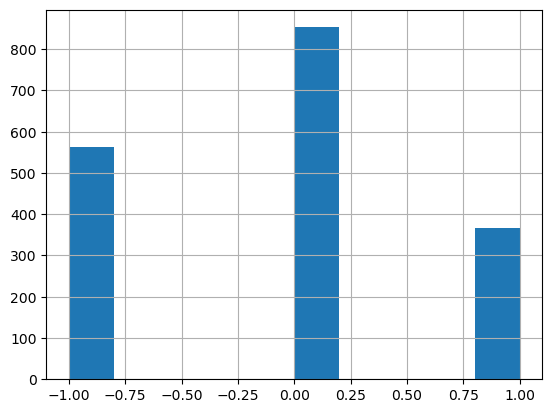

In [276]:
# pitfall one category high frequency
historical_['Target'] = mytarget(30, historical_)

historical_['Target'].hist()

In [277]:
# add target to combined_df_
combined_df_['Target'] = historical_['Target']
combined_df_.head()

,value,Close,change,position,Target
timestamp,,,,,
2018-02-02 00:00:00+00:00,15.0,915.784973,-0.116711,0,0.0
2018-02-03 00:00:00+00:00,40.0,964.018982,0.052670,-1,0.0
2018-02-04 00:00:00+00:00,24.0,834.682007,-0.134164,0,0.0
2018-02-05 00:00:00+00:00,11.0,697.950989,-0.163812,0,0.0
2018-02-06 00:00:00+00:00,8.0,793.122009,0.136358,0,0.0


In [278]:
# copy and clean dataframe
combined_ml = combined_df_.copy()
# add RSI
combined_ml['RSI'] = pa.rsi(combined_ml.Close, length=16)
# get signal column
combined_ml['Signal'] = combined_ml['position']
# drop columns and na
combined_ml = combined_ml.drop(["Close", "change", "position"],axis=1)
combined_ml = combined_ml.dropna()
combined_ml.tail()

,value,Target,RSI,Signal
timestamp,,,,
2022-12-18 00:00:00+00:00,26.0,0.0,42.543164,-1
2022-12-19 00:00:00+00:00,29.0,1.0,41.090983,-1
2022-12-20 00:00:00+00:00,29.0,-1.0,46.767101,-1
2022-12-21 00:00:00+00:00,26.0,0.0,46.376635,-1
2022-12-22 00:00:00+00:00,28.0,1.0,46.904628,-1


In [279]:
# get dummies on signal column
attributes = ['value', 'Target', 'RSI', 'Signal']
model_df = combined_ml[attributes].copy()

combined_ml['Signal'] = pd.Categorical(combined_ml['Signal'])
dummies = pd.get_dummies(combined_ml['Signal'], prefix='signal')
model_df = model_df.drop(['Signal'], axis=1)
model_df = pd.concat([model_df, dummies], axis=1)
model_df.head()

,value,Target,RSI,signal_-1,signal_0,signal_1
timestamp,,,,,,
2018-02-18 00:00:00+00:00,63.0,1.0,53.324972,0,0,1
2018-02-19 00:00:00+00:00,67.0,0.0,55.183005,0,0,1
2018-02-20 00:00:00+00:00,74.0,0.0,50.018759,0,0,1
2018-02-21 00:00:00+00:00,54.0,0.0,45.743818,0,0,1
2018-02-22 00:00:00+00:00,44.0,0.0,42.570200,1,0,0


**Neural Network:**

In [280]:
from sklearn.neural_network import MLPClassifier

# set X and y
attributes = ['value', 'RSI', 'signal_-1', 'signal_0', 'signal_-1']
X = model_df[attributes]
y = model_df['Target']

# split into testing and training
train_pct_index = int(0.6 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# set up NN model
NN = MLPClassifier(hidden_layer_sizes=(5, 100, 60, 3), random_state=100, verbose=0, max_iter=500, activation='relu')
NN.fit(X_train, y_train)
pred_train = NN.predict(X_train)
pred_test = NN.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print("="*20)

# print accuracy
print('Train Results:')
print("Accuracy: {:.4%}".format(acc_train))
print('Test Results:')
print("Accuracy: {:.4%}".format(acc_test)) 

Train Results:
Accuracy: 52.3135%
Test Results:
Accuracy: 27.1570%


In [281]:
# generate confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix_train = confusion_matrix(y_train, pred_train)
matrix_test = confusion_matrix(y_test, pred_test)

report_train = classification_report(y_train, pred_train)
report_test = classification_report(y_test, pred_test)

print(report_train)
print(report_test)

              precision    recall  f1-score   support

        -1.0       0.53      0.91      0.67       509
         0.0       0.49      0.38      0.43       235
         1.0       0.00      0.00      0.00       315

    accuracy                           0.52      1059
   macro avg       0.34      0.43      0.37      1059
weighted avg       0.36      0.52      0.42      1059

              precision    recall  f1-score   support

        -1.0       0.08      0.87      0.15        52
         0.0       0.92      0.24      0.38       608
         1.0       0.00      0.00      0.00        47

    accuracy                           0.27       707
   macro avg       0.33      0.37      0.18       707
weighted avg       0.80      0.27      0.34       707



/opt/anaconda3/envs/dev/envs/algotrading/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/envs/algotrading/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/envs/algotrading/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

**XGBClassifier:**

- **issue:**
Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [-1.  0.  1.]

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss

attributes = ['value', 'RSI', 'signal_-1', 'signal_0', 'signal_1']
X = model_df[attributes]
y = model_df['Target']

train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

**Machine Learning prep:**

In [282]:
# features dataframe
X = model_df[['RSI', 'value', 'signal_-1', 'signal_0', 'signal_1']].shift().dropna()
X.head(10)

,RSI,value,signal_-1,signal_0,signal_1
timestamp,,,,,
2018-02-19 00:00:00+00:00,53.324972,63.0,0.0,0.0,1.0
2018-02-20 00:00:00+00:00,55.183005,67.0,0.0,0.0,1.0
2018-02-21 00:00:00+00:00,50.018759,74.0,0.0,0.0,1.0
2018-02-22 00:00:00+00:00,45.743818,54.0,0.0,0.0,1.0
2018-02-23 00:00:00+00:00,42.570200,44.0,1.0,0.0,0.0
2018-02-24 00:00:00+00:00,47.902109,39.0,1.0,0.0,0.0
2018-02-25 00:00:00+00:00,45.810314,31.0,1.0,0.0,0.0
2018-02-26 00:00:00+00:00,46.264407,33.0,1.0,0.0,0.0
2018-02-27 00:00:00+00:00,48.871824,37.0,1.0,0.0,0.0


In [283]:
# Create the target set (-1 = Short, 0 = Stables, 1 = Long)
y = model_df['Target']
y.value_counts()

 0.0    843
-1.0    561
 1.0    362
Name: Target, dtype: int64

In [284]:
# start of the training period
training_begin = X.index.min()
# ending period for the training data with an offset of 40 months
training_end = X.index.min() + DateOffset(months=40)
display(training_begin)
display(training_end)


Timestamp('2018-02-19 00:00:00+0000', tz='UTC')

Timestamp('2021-06-19 00:00:00+0000', tz='UTC')

In [285]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

display(X_train.head())
display(X_test.head())

,RSI,value,signal_-1,signal_0,signal_1
timestamp,,,,,
2018-02-19 00:00:00+00:00,53.324972,63.0,0.0,0.0,1.0
2018-02-20 00:00:00+00:00,55.183005,67.0,0.0,0.0,1.0
2018-02-21 00:00:00+00:00,50.018759,74.0,0.0,0.0,1.0
2018-02-22 00:00:00+00:00,45.743818,54.0,0.0,0.0,1.0
2018-02-23 00:00:00+00:00,42.570200,44.0,1.0,0.0,0.0


,RSI,value,signal_-1,signal_0,signal_1
timestamp,,,,,
2021-06-19 00:00:00+00:00,41.026683,25.0,1.0,0.0,0.0
2021-06-20 00:00:00+00:00,39.997179,23.0,0.0,1.0,0.0
2021-06-21 00:00:00+00:00,41.977104,21.0,0.0,1.0,0.0
2021-06-22 00:00:00+00:00,35.405009,23.0,0.0,1.0,0.0
2021-06-23 00:00:00+00:00,35.183431,10.0,0.0,1.0,0.0


StandardScaler:

In [286]:
# Scale features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

**SVM:**

In [287]:
# Imports
from sklearn import svm
from sklearn.metrics import classification_report

In [288]:
# Create model
svm_model = svm.SVC()
 
# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
svm_pred = svm_model.predict(X_train_scaled)

# Display the sample predictions
svm_pred[:15]

array([ 0.,  0.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.])

In [289]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_train, svm_pred)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.51      0.87      0.64       518
         0.0       0.57      0.50      0.53       375
         1.0       0.00      0.00      0.00       321

    accuracy                           0.53      1214
   macro avg       0.36      0.46      0.39      1214
weighted avg       0.39      0.53      0.44      1214



/opt/anaconda3/envs/dev/envs/algotrading/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/envs/algotrading/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/envs/algotrading/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

In [290]:
# Create a new empty predictions DataFrame:
testing_signal_predictions = svm_model.predict(X_test_scaled)

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = testing_signal_predictions

# Add the actual returns to the DataFrame
predictions_df['Actual_Returns'] = combined_df_["change"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy_Returns'] = predictions_df["Actual_Returns"] * predictions_df["Predicted"]

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual_Returns,Strategy_Returns
timestamp,,,
2021-06-19 00:00:00+00:00,-1.0,-0.023853,0.023853
2021-06-20 00:00:00+00:00,-1.0,0.031152,-0.031152
2021-06-21 00:00:00+00:00,-1.0,-0.159332,0.159332
2021-06-22 00:00:00+00:00,-1.0,-0.007147,0.007147
2021-06-23 00:00:00+00:00,-1.0,0.061221,-0.061221


,Predicted,Actual_Returns,Strategy_Returns
timestamp,,,
2022-12-18 00:00:00+00:00,-1.0,-0.002890,0.002890
2022-12-19 00:00:00+00:00,-1.0,-0.014438,0.014438
2022-12-20 00:00:00+00:00,-1.0,0.042903,-0.042903
2022-12-21 00:00:00+00:00,-1.0,-0.003370,0.003370
2022-12-22 00:00:00+00:00,-1.0,0.003776,-0.003776


<AxesSubplot:xlabel='timestamp'>

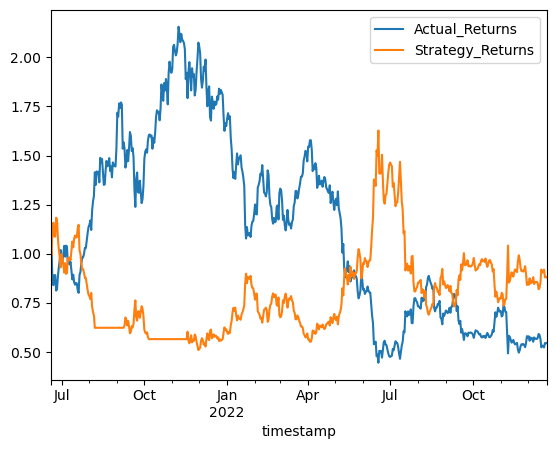

In [291]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual_Returns", "Strategy_Returns"]]).cumprod().plot()

- This model does a decent job of predicting when to short(-1), but it does not predict buy oppurtunities.